In [212]:
# import dlm and its modeling components
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
import lightgbm as lgb
import numpy as np
import pandas as pd
from fbprophet import Prophet
from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
DATE = "2020-05-05"

In [213]:
df = pd.read_csv("processed_data.csv")
df.columns = ['Date', 'Infected', 'Fatal', 'Cured']
features = [[df['Cured'][i], df['Fatal'][i]] for i in range(0, len(df['Cured']))]
df.head()
print(features)

[[0.0, 0.0], [0.0, 1.0], [0.0, 0.0], [0.0, 2.0], [0.0, 1.0], [3.0, 3.0], [3.0, 3.0], [3.0, 3.0], [0.0, 2.0], [9.0, 1.0], [0.0, 2.0], [5.0, 1.0], [0.0, 0.0], [3.0, 2.0], [3.0, 2.0], [3.0, 0.0], [4.0, 3.0], [0.0, 5.0], [5.0, 2.0], [0.0, 0.0], [3.0, 0.0], [3.0, 0.0], [0.0, 0.0], [3.0, 4.0], [42.0, 6.0], [12.0, 1.0], [1.0, 1.0], [18.0, 3.0], [25.0, 0.0], [15.0, 2.0], [21.0, 3.0], [24.0, 1.0], [48.0, 1.0], [29.0, 0.0], [36.0, 1.0], [37.0, 2.0], [126.0, 2.0], [53.0, 4.0], [36.0, 6.0], [38.0, 2.0], [111.0, 4.0], [69.0, 4.0], [45.0, 1.0], [95.0, 2.0], [47.0, 1.0], [21.0, 1.0], [44.0, 2.0], [22.0, 0.0], [20.0, 1.0], [13.0, 1.0], [13.0, 1.0], [64.0, 0.0], [5.0, 1.0], [24.0, 3.0]]


In [214]:
df.set_index("Date", drop=False, inplace=True)
data = df['Infected'].tolist()
data = list(map(int, data))
len(data)

54

In [215]:
# construct the base
myDLM = dlm(data)
# adding model components
# add a first-order trend (linear trending) with prior covariance 1.0
myDLM = myDLM + trend(1, name='lineTrend', w=1.0)
# add a 7 day seasonality with prior covariance 1.0
myDLM = myDLM + seasonality(7, name='7day', w=1.0)
# add a 3 step auto regression
myDLM = myDLM + autoReg(degree=3, data=data, name='ar3', w=1.0)
# show the added components
myDLM.ls()
# delete unwanted component
myDLM.delete('7day')
myDLM.ls()

The static components are
lineTrend (degree = 2)
7day (degree = 7)
 
There is no dynamic component.
 
The automatic components are
ar3 (dimension = 3)
The static components are
lineTrend (degree = 2)
 
There is no dynamic component.
 
The automatic components are
ar3 (dimension = 3)


In [216]:
# fit forward filter
myDLM.fitForwardFilter()
# fit backward smoother
myDLM.fitBackwardSmoother()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


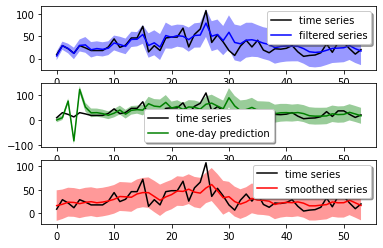

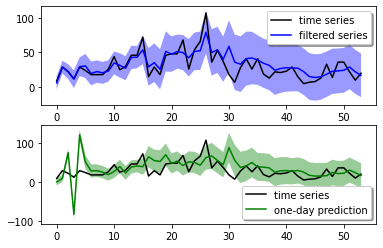

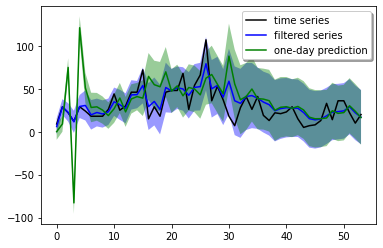

In [217]:
from matplotlib import pyplot as plt
# plot the results
myDLM.plot()
# plot only the filtered results
myDLM.turnOff('smoothed plot')
myDLM.plot()
# plot in one figure
myDLM.turnOff('multiple plots')
myDLM.plot()

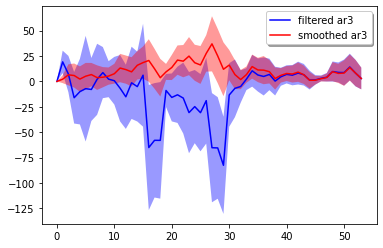

In [218]:
# plot the component mean of 'ar3'
myDLM.turnOn('smoothed plot')
myDLM.turnOff('predict')
myDLM.plot(name='ar3')

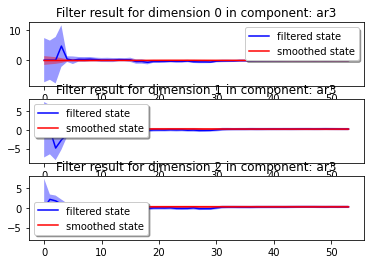

In [219]:
myDLM.plotCoef(name='ar3')

In [220]:
myDLM.getMSE()

815.4591756380463

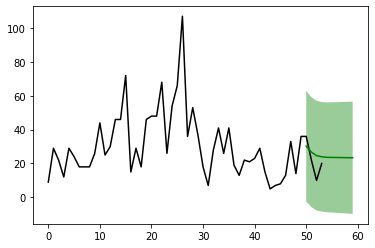

In [221]:
myDLM.plotPredictN(date=50, N=10)

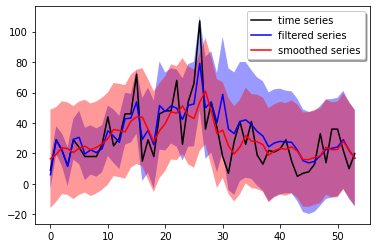

In [222]:
myDLM.plot()

In [223]:
# A linear trend
linear_trend = trend(degree=1, discount=0.95, name='linear_trend', w=10)
# A seasonality
seasonal52 = seasonality(period=48, discount=0.99, name='seasonal52', w=10)
# Build a simple dlm
simple_dlm = dlm(data) + linear_trend + seasonal52

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


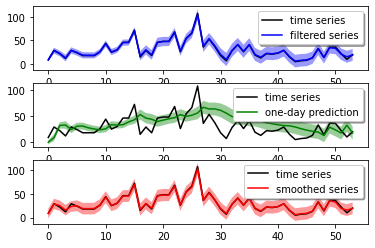

In [224]:
# Fit the model
simple_dlm.fit()
# Plot the fitted results
simple_dlm.turnOff('data points')
simple_dlm.plot()

In [225]:
simple_dlm.getMSE()

379.4371081590385

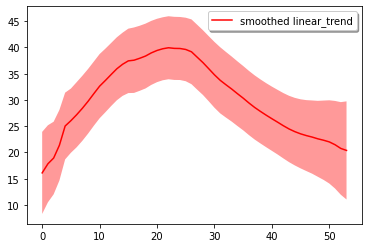

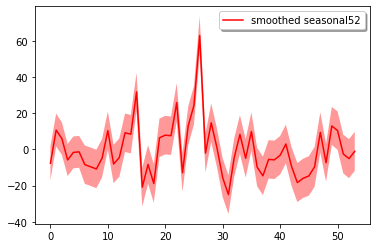

In [226]:
# Plot each component (attribute the time series to each component)
simple_dlm.turnOff('predict plot')
simple_dlm.turnOff('filtered plot')
simple_dlm.plot('linear_trend')
simple_dlm.plot('seasonal52')

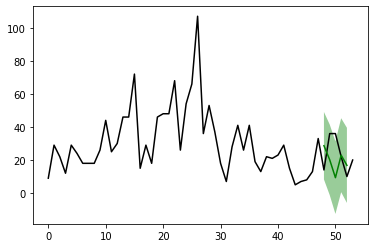

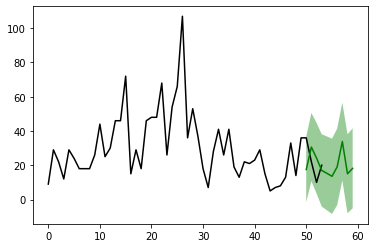

In [227]:
# Plot the prediction give the first 351 weeks and forcast the next 200 weeks.
simple_dlm.plotPredictN(date=48, N=5)
# Plot the prediction give the first 251 weeks and forcast the next 200 weeks.
simple_dlm.plotPredictN(date=50, N=10)

In [228]:
# Build a dynamic regression model
from pydlm import dynamic
regressor10 = dynamic(features=features, discount=1.0, name='regressor10', w=10)
drm = dlm(data) + linear_trend + seasonal52 + regressor10
drm.fit()
drm.getMSE()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


466.8397089734106

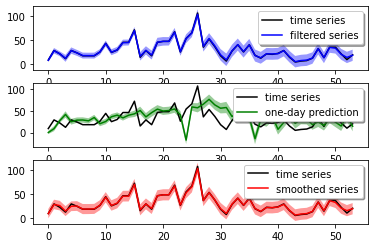

In [229]:
# Plot the fitted results
drm.turnOff('data points')
drm.plot()

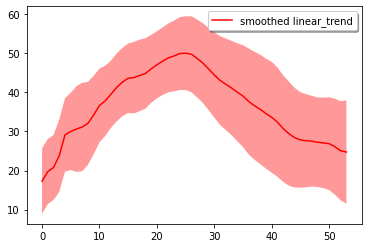

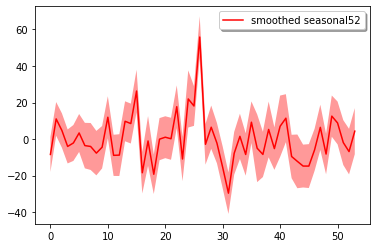

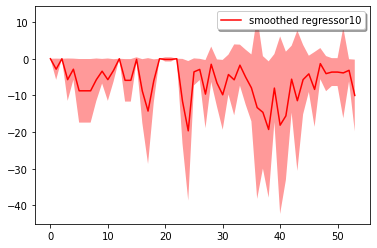

In [230]:
drm.turnOff('predict plot')
drm.turnOff('filtered plot')
drm.plot('linear_trend')
drm.plot('seasonal52')
drm.plot('regressor10')

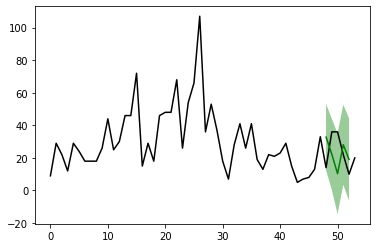

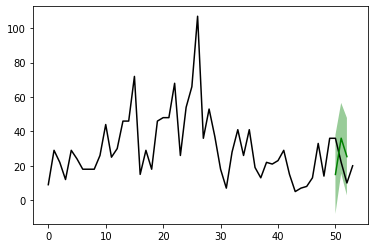

In [231]:
drm.plotPredictN(date=48, N=5)
drm.plotPredictN(date=50, N=3)